In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.linear_model import LinearRegression as SK_LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

sys.path.append('../')
from supervised import LinearRegression

### Need some Data

The goal of this notebook is to compare my own implementations of Linear Regression to scikit-learn's implementation. I will do this on both linear and polynomial data. But I will need some data first. Cell directly below will hold the functions I will be using throughout this notebook for data generation. It is super duper simple, so the data will not have a ton of nuance. But it will be enough to get the point across.

In [2]:
def generate_polynomial_dataset(num_samples, degree, noise, x_range=(0, 1), seed=42):
    """
    Generate a dataset with a polynomial relationship between a single feature and target. 
    
    Parameters:
        num_samples (int): number of samples to generate
        degree (int): degree of polynomial
        noise (float): standard deviation of gaussian noise
        x_range (tuple): range of x values
        seed (int): random seed
    Returns:
        X (num_samples, 1): feature vector for unscaled x value
        y (np.ndarray): target vector
        degree (int): degree of polynomial
    """
    assert degree > 0, "degree must be greater than 0"
    np.random.seed(seed)

    # generate random weights
    w = np.random.uniform(-1, 1, degree+1)

    X = np.random.uniform(x_range[0], x_range[1], (num_samples, 1))
    
    for i in range(2, degree+1):
        X = np.hstack((X, np.power(X[:,0], i).reshape(-1, 1)))
    
    X = np.hstack((np.ones((num_samples, 1)), X)) # add bias term

    noise = np.random.normal(0, noise, num_samples)

    y = np.dot(X, w) + noise

    return X[:,1].reshape(-1, 1), y, degree


### Part 1: Regression on Linear Data


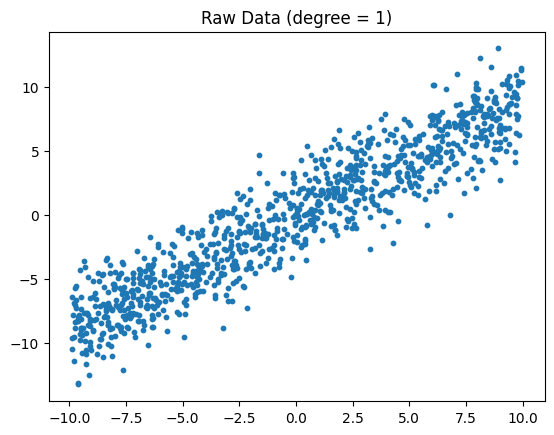

In [3]:
X, y, degree = generate_polynomial_dataset(1000, 1, noise=2, x_range=(-10, 10))

plt.scatter(X, y, s=10)
plt.title('Raw Data (degree = {})'.format(degree))
plt.show()

### EZ PZ Linear Regression: See `linear_regression.py` for implementation details

In [4]:
LR_closed = LinearRegression() # my own closed form solution (No learning required!)
LR_grad = LinearRegression() # my own gradient descent solution
SK_LR = SK_LinearRegression() # sklearn's solution
LR_closed.fit_cfs(X, y)
LR_grad.fit_gd(X, y, lr=0.01, epochs=1000)
SK_LR.fit(X, y) # sklearn's solution no bias term needed

print("NOTICE: the weights between CFS and SK are the same, but the weights between GD and SK are different. \nIf I ran GD for more epochs, the weights would converge to the same as SK.")
print('CFS weights: {} '.format(LR_closed._weights))
print('GD weights: {}'.format(LR_grad._weights))
print('SK weights: {}'.format(np.concatenate(([SK_LR.intercept_], SK_LR.coef_))))

NOTICE: the weights between CFS and SK are the same, but the weights between GD and SK are different. 
If I ran GD for more epochs, the weights would converge to the same as SK.
CFS weights: [-0.05672612  0.88724118] 
GD weights: [-0.05678949  0.88724078]
SK weights: [-0.05672612  0.88724118]


SK MSE: 3.902129903519301
CFS MSE: 3.9021299035193016
GD MSE: 3.9021299075294613


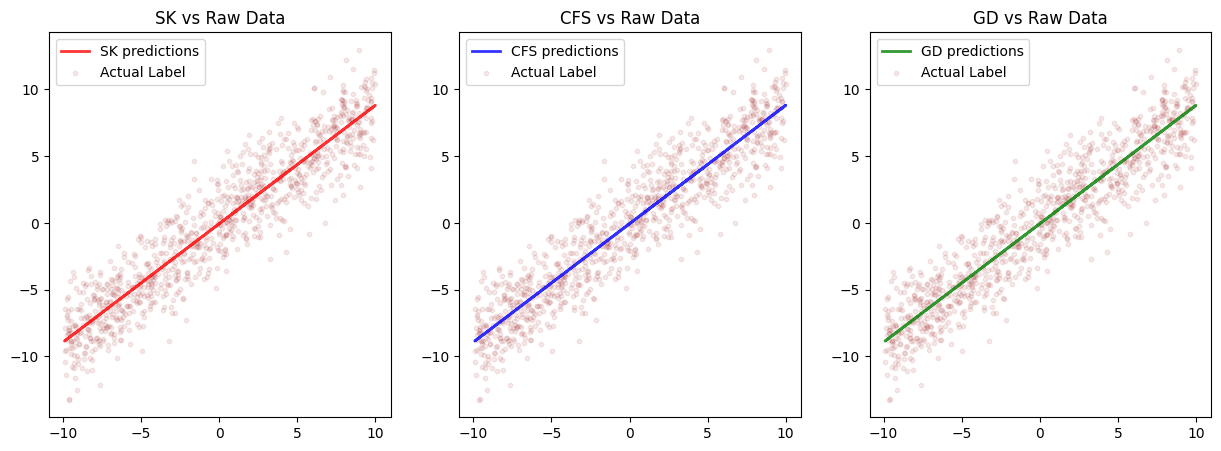

In [5]:
sk_preds = SK_LR.predict(X)
cfs_preds = LR_closed.predict(X)
gd_preds = LR_grad.predict(X)

preds = [sk_preds, cfs_preds, gd_preds]
pred_label = ['SK', 'CFS', 'GD']
colors = ['red', 'blue', 'green']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].plot(X[:,0], preds[i], label=f'{pred_label[i]} predictions', c=colors[i], alpha=0.8, linewidth=2)
    ax[i].scatter(X[:,0], y, s=10, label='Actual Label', c='brown', alpha=0.1)    
    ax[i].set_title(f'{pred_label[i]} vs Raw Data')
    ax[i].legend()

print('SK MSE: {}'.format(mean_squared_error(y, sk_preds)))
print('CFS MSE: {}'.format(mean_squared_error(y, cfs_preds)))
print('GD MSE: {}'.format(mean_squared_error(y, gd_preds)))

### Polynomial Data!

What if data is does not have a linear relationship between x and y? Let's see...

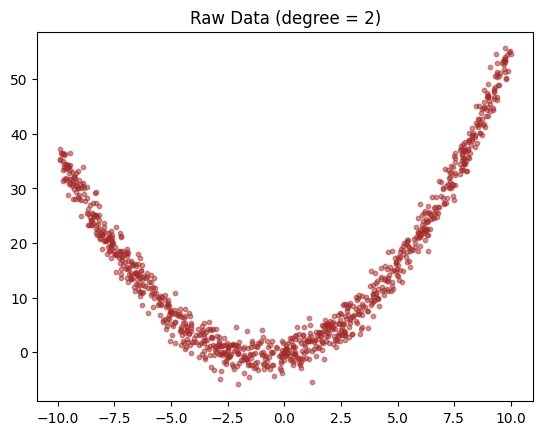

In [6]:
# quadratic dataset
X, y, degree = generate_polynomial_dataset(1000, 2, noise=2, x_range=(-10, 10)) # y follows a quadratic relationship with x

plt.scatter(X, y, s=10, c='brown', alpha=0.5)
plt.title(f'Raw Data (degree = {degree})')
plt.show()

### Notice: 
Plugging X into LR model with no transformation doesn't work well as it tries to fit a line to a curve...

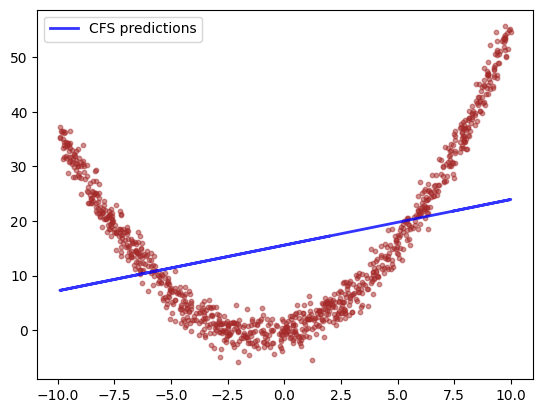

In [7]:
LR_closed = LinearRegression()
LR_closed.fit_cfs(X, y)

plt.scatter(X, y, s=10, c='brown', alpha=0.5)
plt.plot(X, LR_closed.predict(X), c='blue', alpha=0.8, linewidth=2, label='CFS predictions')
plt.legend()
plt.show()

### Using PolynomialFeatures to transform X to X_poly

By looking at the raw data, one could assume it follows a quadratic function:

$$y = a x^2 + b x + c$$

Assuming this is the case and our goal is to transform our data into features to match the above equation. E.g.

$$[x] \rightarrow [x^2, x, 1]$$ 

and learn the coefficients 

$$[a, b, c]$$

In [8]:
X_poly = PolynomialFeatures(degree=2).fit_transform(X)[:,1:] # remove bias term

LR_closed = LinearRegression()
LR_grad = LinearRegression()
SK_LR = SK_LinearRegression()

LR_closed.fit_cfs(X_poly, y)
LR_grad.fit_gd(X_poly, y, lr=0.0001, epochs=100_000) # need to use a smaller learning rate and more epochs for higher degree polynomials
SK_LR.fit(X_poly, y)

print('CFS weights: {} '.format(LR_closed._weights))
print('GD weights: {}'.format(LR_grad._weights))
print('SK weights: {}'.format(np.concatenate(([SK_LR.intercept_], SK_LR.coef_))))

CFS weights: [-0.23705326  0.9165006   0.46397513] 
GD weights: [-0.24637044  0.91650319  0.46412961]
SK weights: [-0.23705326  0.9165006   0.46397513]


CFS MSE: 3.7260588406716044
GD MSE: 3.7260965421776655
SK MSE: 3.7260588406716044


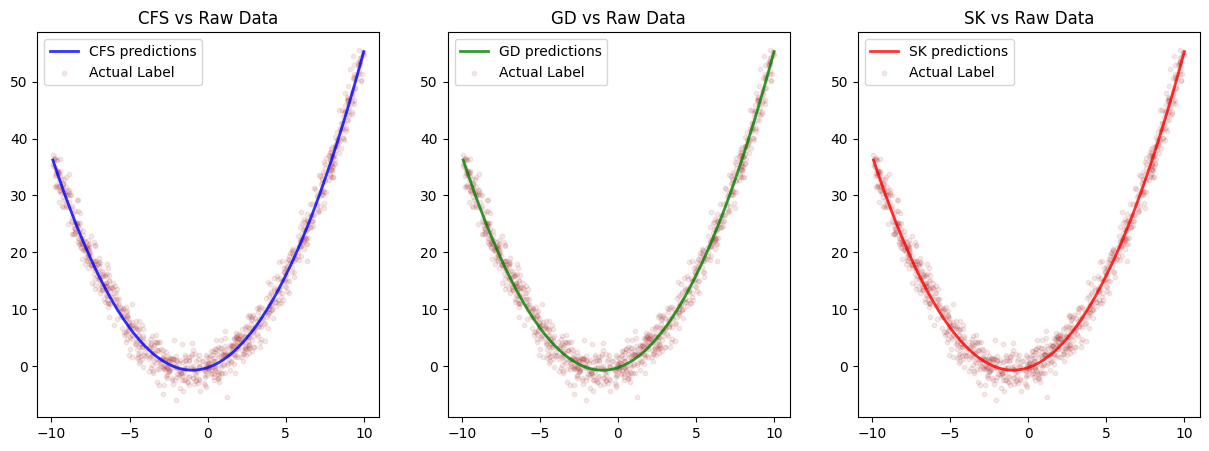

In [9]:
preds = [LR_closed.predict(X_poly), LR_grad.predict(X_poly), SK_LR.predict(X_poly)]
pred_label = ['CFS', 'GD', 'SK']
colors = ['blue', 'green', 'red']

plottable_data = []

for pred in preds:
    x_y = zip(X, pred)
    x_y = sorted(x_y, key=lambda x: x[0])
    X_v, pred = zip(*x_y)
    plottable_data.append((X_v, pred))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    X_v, pred = plottable_data[i]
    ax[i].plot(X_v, pred, label=f'{pred_label[i]} predictions', c=colors[i], alpha=0.8, linewidth=2)
    ax[i].scatter(X, y, s=10, label='Actual Label', c='brown', alpha=0.1)    
    ax[i].set_title(f'{pred_label[i]} vs Raw Data')
    ax[i].legend()

print('CFS MSE: {}'.format(mean_squared_error(y, preds[0])))
print('GD MSE: {}'.format(mean_squared_error(y, preds[1])))
print('SK MSE: {}'.format(mean_squared_error(y, preds[2])))